# Figure 2

The data needed to reproduce this figure is computed from the raw data by running the "aggregate_data.ipynb" notebook. The parameters of the analysis of Zipf's law are computed from the notebook "model_fitting.ipynb". We also overlay some daily data that is found on Zenodo and fitted lines that arise from running the model_fitting notebook. The Figure 2 bottom panel is computed using the accumulated data in the "Data" folder.

In [1]:
import os, sys, codecs
import numpy as np
import pylab as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.cm as cm
import gzip
import pandas as pd
import ast

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.pardir,'src')))

from modules_distributor import fit
from modules_fitting_lognormal import *
from general import *

Reading in the combined data

In [3]:
path = "../Data/"
fout_name = 'combined_data' # name of the output file

f = open(path + fout_name + ".csv.gz", "r")
contents = f.read()
f.close()    

res_list_temp = contents.split("\n")

In [4]:
all_hashtags = []
all_counts = []

for i in range(len(res_list_temp)-1): # last element is empty, we cannot split it by ","

    split_result = res_list_temp[i].split(",")
    all_hashtags.append(split_result[0])
    all_counts.append(int(split_result[1]))

# Plotting the rank-frequency distribution

In [6]:
arr_r = np.arange(len(all_hashtags)) + 1
arr_count = np.sort(all_counts)[::-1]
arr_f = arr_count/sum(all_counts)

It is too expensive to plot ~58 million points. For the hashtags that aren't used often (determined by target_num), we find the index of when they first and last occur. Then connect the two points with a line.

In [7]:
target_num = 100

index_occ = []
freq_temp = []

for i in range(target_num, 0, -1):
    index_occ.append(np.where(arr_count == i)[0][0]) #start
    freq_temp.append(i/sum(all_counts))
    
    if (not i == 1): #we do the case i = 1 manually in the next segment
        index_occ.append(np.where(arr_count == i - 1)[0][0] - 1) #end
        freq_temp.append(i/sum(all_counts))

In [8]:
# We also have to add on when the data ends. the last hashtag with 1 occurence. (print freq_temp if this isn't clear)
index_occ.append(len(all_counts))
freq_temp.append(1/sum(all_counts))

In [9]:
# Combining the indvidual points of highly used hashtags with what we did above
plot_x = np.concatenate([arr_r[:int(np.where(arr_count == target_num)[0][0])], np.asarray(index_occ)])
plot_y = np.concatenate([arr_f[:int(np.where(arr_count == target_num)[0][0])], np.asarray(freq_temp)])

Using the predicted rank-frequncy distributions using the models fitted in model_fitting.ipynb.
The fitted results such as parameteres and log likelihoods is now in the "output" folder.

In [10]:
fitted_path = "../output/"
fitted_file = "combined_data-nrep10.txt"

In [11]:
results_list = get_fitted_data(fitted_path, fitted_file)

| Model         | Param estimates              |  Negative Log Lik/$M$    |
|---------------|------------------------------|--------------------------|
|Simple         |   1.1122                     |    11.5438               |
|Double PL      |   1.57, 352288.8             |    11.1859               |
|Log-normal     |   8.25, 3.8327               |    11.0753               |
|Naranan        |   1.156, 5.0930              |    11.3472               |
|Exp Cutoff     |   0.9605, 1.1146             |    11.1954               |
|Weibull        |   -0.2416, 4.51307           |    12.1747               |
|Shifted        |   1.24855, 119.765           |    11.2051               |
|Double Gamma   |   0.8083, 1.4079, 18145.1    |    11.0912               |

Parameters are given in the order found in Table I of the paper. For most models, we have $\gamma$ followed by $b$. For the log-normal model, we have $m$ followed by $s$ and for the double gamma model, the order is $\gamma_1$, $\gamma_2$ and $b$ .

In [12]:
simple_gamma = results_list[0][0][0]

lognormal_mu = results_list[2][0][0]
lognormal_sigma = results_list[2][0][1]

rmin_fit = 1
rmax_fit = np.Inf # used when fitting

In [15]:
C = 1/np.sum(np.power(arr_r, -simple_gamma)) #normalizing constant for the simple model
arr_f_fit_simple = C/plot_x ** simple_gamma
arr_f_fit_lognormal = pdf_lognormal_disc(plot_x, rmin_fit, rmax_fit, lognormal_mu, lognormal_sigma)

In [16]:
day_path = "../hashtags_frequency_day/"
day_files = sorted(get_zipped_files(day_path, ".gz"))

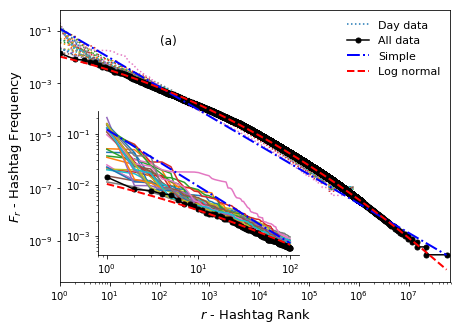

In [31]:
params = {'figure.figsize': [7, 5]}

plt.rcParams.update(params)

fig, ax1 = plt.subplots()

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.2, 0.2, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])

for i in range(0, 30): # only 30 daily plots
    res_temp = get_data(day_path, day_files[i], "day")

    hashtags = list(res_temp.keys())
    counts = list(res_temp.values())
    
    if (len(hashtags)) == 0 or  len(hashtags) < 400000: # corrupted files
        pass
    else:
        arr_r = np.arange(len(counts)) + 1
        arr_f = np.sort(counts)[::-1]/float(np.sum(counts))
        
        plot_r = arr_r[:100] # plot only the top 10 ranks in inset
        plot_f = arr_f[:100]

        if i == 0:
            ax1.plot(arr_r, arr_f, linestyle = ":", label = "Day data")
        else:
            ax1.plot(arr_r, arr_f, linestyle = ":")
            
        ax2.plot(plot_r, plot_f)
        ax2.loglog()

ax1.plot(plot_x, plot_y, label = 'All data', color = "black", marker = "o", markersize = 5)
ax1.plot(plot_x, arr_f_fit_simple, "-.", label = 'Simple', color = "blue", linewidth = 2) 
ax1.plot(plot_x, arr_f_fit_lognormal, "--", label = 'Log normal', color = "red", linewidth = 2)

ax2.plot(plot_x[:100], plot_y[:100], color = "black", marker = "o", markersize = 5)
ax2.plot(plot_x[:100], arr_f_fit_simple[:100], "-.", label = 'Simple', color = "blue", linewidth = 2) 
ax2.plot(plot_x[:100], arr_f_fit_lognormal[:100], "--", label = 'Log normal', color = "red", linewidth = 2)

ax1.loglog()
ax1.legend(loc = "upper right", frameon = False, prop={'size': 11})
ax1.set_xlabel(r'$r$' + " - Hashtag Rank", fontsize = 13)
ax1.set_ylabel(r'$F_r$' + " - Hashtag Frequency", fontsize = 13)
ax1.text(100, 3 * 10e-3, "(a)", fontsize = 12)
ax1.set_xlim(1, max(plot_x) * 1.2)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')

ax2.patch.set_alpha(0.0) #transparent background for inset

plt.show()
fig = plt.gcf()
size = fig.get_size_inches()

We have ~58 million unique hashtags. i.e: hashtag types.

In [20]:
max(plot_x)

57876308

How does the parameter varies for different bin sizes for the log-normal model?

In [3]:
fitted_path = '../output/Cumulative/Zipf_fitted/'
list_of_files = []

for file in os.listdir(fitted_path):
    if file.endswith("_cum-nrep2.txt"): # replace with higher repetition if avaliable
        list_of_files.append(file)

In [15]:
lognormal_m = []
lognormal_s = []

In [16]:
for file in list_of_files:
    results_list = get_fitted_data(fitted_path, file)  
    lognormal_results = results_list[2]
    
    if (lognormal_results[1]) == 0: # corrupted files and non-convergent results
        lognormal_m.append(None)
        lognormal_s.append(None)
    else:
        lognormal_m.append(lognormal_results[0][0])
        lognormal_s.append(lognormal_results[0][1])

In [17]:
lognormal_m

[6.387406231145541,
 6.3299767249970795,
 6.865664471675445,
 7.383685220878777,
 7.182917132909406,
 6.7883737271299776,
 7.043047788073785,
 7.535608740847245,
 8.02563271562456,
 8.249493929866771]

In [18]:
lognormal_s

[3.864944906638473,
 4.070659196215368,
 3.9001750009469562,
 3.6373637532297556,
 3.826605606884474,
 4.254770750897561,
 4.260230190653147,
 4.078695978450361,
 3.91949621871857,
 3.832717580455707]

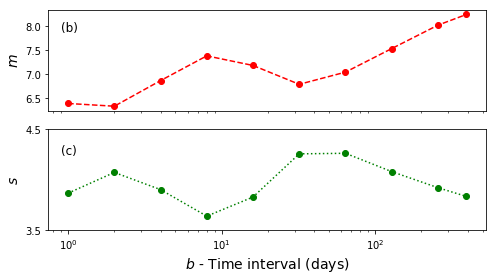

In [23]:
given_intervals_temp = np.power(2, [0, 1, 2, 3, 4, 5, 6, 7, 8])
given_intervals = np.concatenate(([0], given_intervals_temp, [392]))

params = {'figure.figsize': [7, 4]}

plt.rcParams.update(params)
fig = plt.figure()

plt.subplot(2, 1, 1)

plt.plot(given_intervals[1:], lognormal_m, "o--", color = "red", label = r"$m$")
plt.xscale("log")
plt.xticks([])
plt.ylabel(r"$m$", fontsize = 14)
plt.text(0.9, 7.9, "(b)", fontsize = 12)

plt.subplot(2, 1, 2)
plt.plot(given_intervals[1:], lognormal_s, "o--", color = "green", label = r"$\sigma$")
plt.yticks([3.5, 4.5], [3.5, 4.5])
plt.ylabel(r"$s$", fontsize = 14)
plt.xscale("log")
plt.text(0.9, 4.25, "(c)", fontsize = 12)

plt.xlabel(r"$b$ - Time interval (days)", fontsize = 14)
plt.tight_layout()
plt.show()